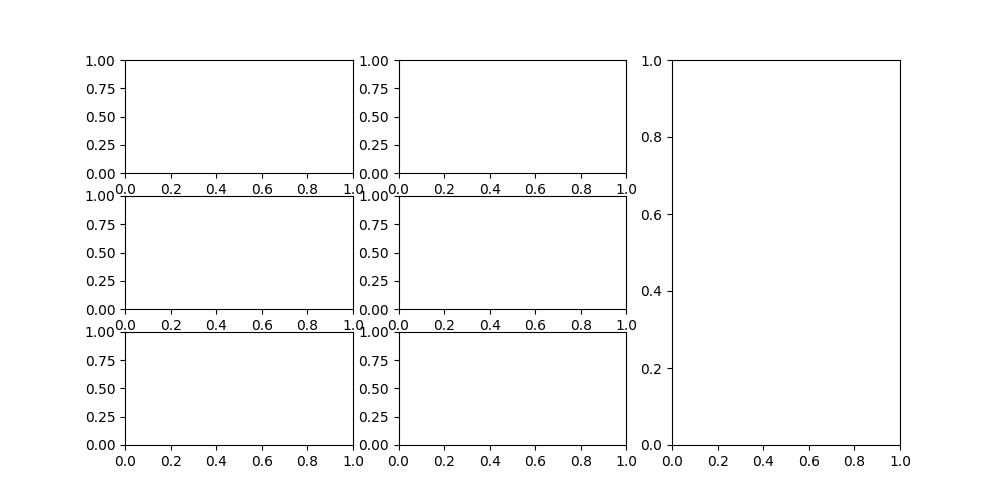

In [15]:
# fig = plt.figure(figsize=(10, 5))
# fig.add_subplot(331)
# fig.add_subplot(332)
# fig.add_subplot(334)
# fig.add_subplot(335)
# fig.add_subplot(337)
# fig.add_subplot(338)
# fig.add_subplot(133)



# plt.show()

/home/s1803229/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


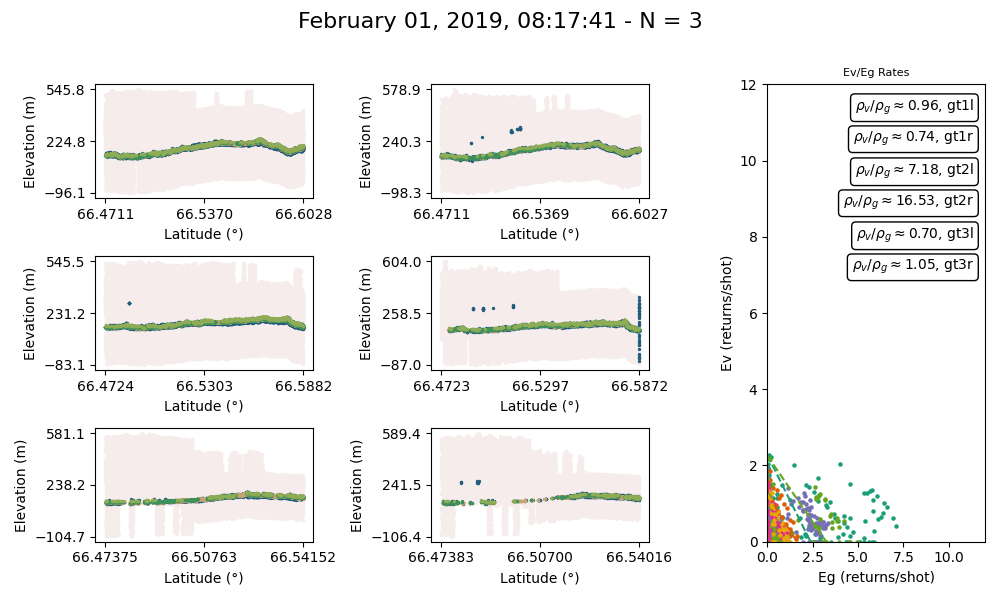

In [1]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *

%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

def pvpg_concise(atl03path, atl08path,f_scale = .1, loss = 'arctan', bounds = ([-100, 0], [-1/100, 16]), file_index = None, res = residuals, model = model, rt = None, zeros=False):
    """
    Regression of all tracks on a given overpass fit into a more concise visual representation

    atl03path - Path/to/ATL03/file
    atl08path - Path/to/matching/ATL08/file
    f_scale - Parameter in least_squares() function when loss is nonlinear, indiciating the value of the soft margin between inlier and outlier residuals.
    loss - string for loss parameter in least_squares().
    bounds - bounds for slope of line and y-intercept in shape ([--,--],[--,--]), allowing us to restrict the regression to realistic values.
    file_index - Index of file if cycling through an array of filenames, displayed in figure titles for a given file. Allows us to easily pick out strange cases for investigation.
    res - Default holds the ODR residuals function to be used in least_squares(). Can hold adjusted residual functions as well.
    model - model function to be used, e.g. params[0]*x + params[1]
    rt - this will trigger RANSAC regression, and is also equal to the residual threshold of the regression.
    """
    
    i = 0
    
    tracks = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
    A = h5py.File(atl03path, 'r')
        
    for gt in tracks:
        try:
            if 0 in A[gt]['geolocation']['ph_index_beg']:
                print('File ' + str(file_index) + ' has been skipped.')
                A.close()
                return
                # This block will be executed if 0 is found in the list
        except (KeyError, FileNotFoundError):
            # Handle the exception (e.g., print a message or log the error)
            continue
    
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(334)
    ax4 = fig.add_subplot(335)
    ax5 = fig.add_subplot(337)
    ax6 = fig.add_subplot(338)
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    ax7 = fig.add_subplot(133)
    
    # Extracting date and time from the filename
    title_date = parse_filename_datetime(atl03path)

    # Set the figure title
    if file_index != None:
        fig.suptitle(title_date + ' - N = ' + str(file_index), fontsize=16)
    else:
        fig.suptitle(title_date, fontsize=16)

    for i, gt in enumerate(tracks):
        
        try:
            atl03 = ATL03(atl03path, atl08path, gt)
        except (KeyError, ValueError, OSError) as e:
            i += 1
            continue
        if zeros == False:
            atl08 = ATL08(atl08path, gt)
        else:
            atl08 = ATL08_with_zeros(atl08path, gt)

        atl03.plot_small(axes[i])

        X = atl08.df.Eg
        Y = atl08.df.Ev
        
        init = [-1, np.max(Y)]
        
        if rt != None:
            a_guess, b_guess, ransac_model, inlier_mask = run_ransac(X, Y, loss=loss, rt=rt)
            ax7.scatter(X,Y, s=5, label=f"{gt} - RANSAC", color=cmap2(i))
        
        else:
            a_guess, b_guess = odr(X, Y, res = res, init=init, loss=loss, bounds=bounds, f_scale=f_scale)
            ax7.scatter(X,Y, s=5, label=f"{gt} - ODR", color=cmap2(i))
        ax7.plot(np.array([0,12]), model([a_guess, b_guess], np.array([0,12])), label='Orthogonal Distance Regression', color=cmap2(i), linestyle='--', zorder=2)
        ax7.annotate(r'$\rho_v/\rho_g \approx {:.2f}$, {}'.format(-a_guess, gt),
                       xy=(.95,.97-.07*i),
                       xycoords='axes fraction',
                       ha='right',
                       va='top',
                       bbox=dict(boxstyle="round,pad=0.3",
                                 edgecolor="black",
                                 facecolor="white"))
        i += 1
        
    ax7.set_title(f"Ev/Eg Rates", fontsize=8)
    ax7.set_xlabel('Eg (returns/shot)')
    ax7.set_ylabel('Ev (returns/shot)')
    ax7.set_xlim(0,12)
    ax7.set_ylim(0,12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout to make room for the suptitle
    plt.show()
    return

for j in range(3,4):
    pvpg_concise(all_ATL03[j],all_ATL08[j],
                           f_scale=.1,
                           loss = 'arctan',
                           file_index=j,
                           zeros = True)

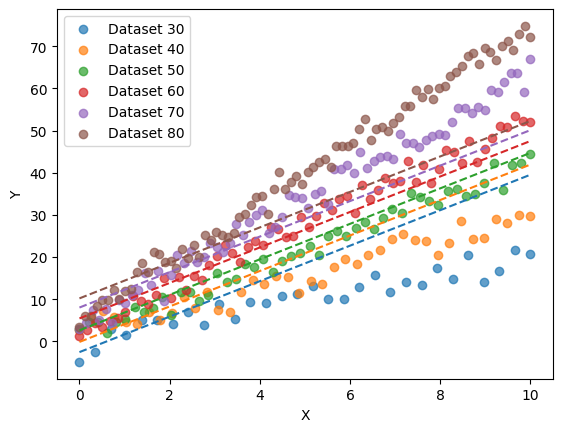

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Function to generate synthetic data with some noise
def generate_data(slope, intercept, num_points):
    x = np.linspace(0, 10, num_points)
    y = slope * x + intercept + np.random.normal(scale=2, size=num_points)
    return x, y

# Define the model function for least squares optimization
def model(params, x, num_datasets):
    common_slope, *intercepts = params
    return [common_slope * x + intercept for intercept in intercepts]

# Define the residual function for least squares optimization
def residual(params, x, num_datasets, *datasets):
    model_outputs = model(params, x, num_datasets)

    all_residuals = []
    for model_output, dataset in zip(model_outputs, datasets):
        residuals = model_output - dataset
        non_nan_residuals = residuals[~np.isnan(residuals)]
        all_residuals.extend(non_nan_residuals)

    return np.array(all_residuals)

# Function to perform parallel regression for an arbitrary number of datasets
def perform_parallel_regression(num_datasets):
    # Generate synthetic data for each dataset
    datasets = [generate_data(2 + i, i, 30 + i * 10) for i in range(num_datasets)]

    # Unpack datasets
    xs, ys = zip(*datasets)

    # Create one-dimensional DataFrames
    xis = [pd.Series(x) for x in xs]
    yis = [pd.Series(y) for y in ys]

    # Concatenate all datasets
    all_x = pd.concat(xis)
    all_y = pd.concat(yis)

    # Set better initial values for parameters
    initial_params = [1] + [1] * num_datasets  # Common slope and initial intercepts

    # Perform least squares regression with a common slope for all datasets and individual intercepts
    params = least_squares(residual, x0=initial_params, args=(all_x, num_datasets, *yis)).x

    # Extract the common slope and individual intercepts for each dataset
    common_slope, *intercepts = params

    # Plot the original datasets and the regression lines with the common slope
    for xi, yi, intercept in zip(xis, yis, intercepts):
        plt.scatter(xi, yi, label=f'Dataset {len(xi)}', alpha=0.7)

        regression_line = common_slope * xi + intercept
        plt.plot(xi, regression_line, '--')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

# Example: Perform parallel regression for 3 datasets
perform_parallel_regression(6)


/home/s1803229/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


0      0.464670
1      0.929161
2      0.837475
3      0.727310
4      0.796483
         ...   
141    3.679571
142    3.438853
143    3.707046
144    3.515331
145    3.646651
Length: 122, dtype: float32
0      1.475945
1      1.978899
2      1.931609
3      1.786157
4      1.865714
         ...   
141         NaN
142         NaN
143         NaN
144         NaN
145         NaN
Length: 122, dtype: float32
0      2.169818
1      2.635378
2      2.525989
3      2.491207
4      2.534152
         ...   
141         NaN
142         NaN
143         NaN
144         NaN
145         NaN
Length: 122, dtype: float32
0      3.086846
1      3.509355
2      3.415589
3      3.399042
4           NaN
         ...   
141         NaN
142         NaN
143         NaN
144         NaN
145         NaN
Length: 122, dtype: float32
0      4.196008
1           NaN
2      4.440819
3      4.466243
4           NaN
         ...   
141         NaN
142         NaN
143         NaN
144         NaN
145         NaN
Length: 

ValueError: Residuals are not finite in the initial point.

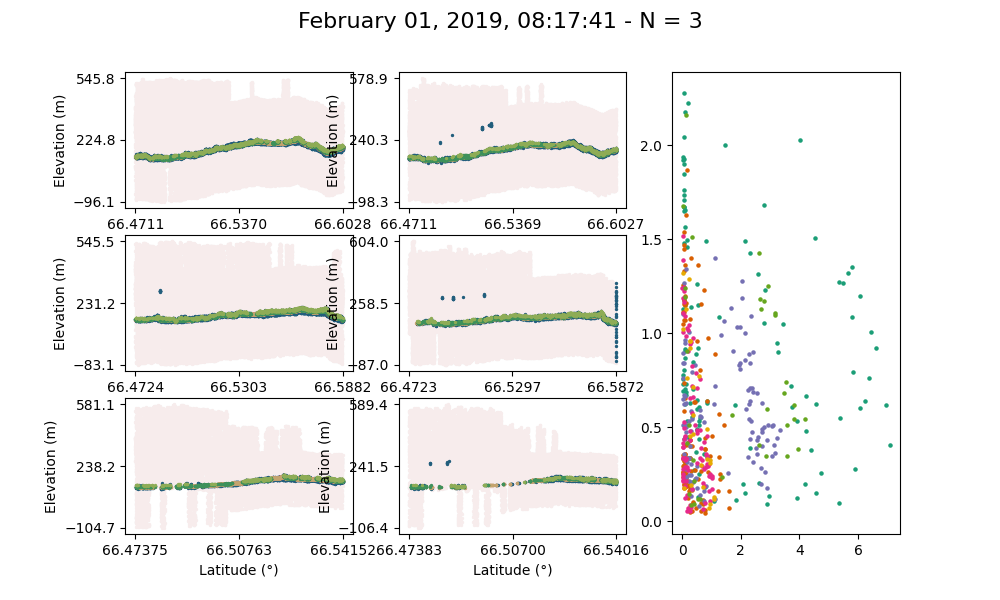

In [1]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *
from scripts.odr import parallel_residuals, parallel_odr

%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

def pvpg_parallel(atl03path, atl08path,f_scale = .1, loss = 'arctan', init = -1, lb = -100, ub = -1/100, file_index = None, model = model, rt = None, zeros=False):
    """
    Parallel regression of all tracks on a given overpass.

    atl03path - Path/to/ATL03/file
    atl08path - Path/to/matching/ATL08/file
    f_scale - Parameter in least_squares() function when loss is nonlinear, indiciating the value of the soft margin between inlier and outlier residuals.
    loss - string for loss parameter in least_squares().
    lb - Lower bound of allowed value for the slope of the regression, default -100
    ub - Upper bound of allowed value for the slope of the regression, default -1/100
    file_index - Index of file if cycling through an array of filenames, displayed in figure titles for a given file. Allows us to easily pick out strange cases for investigation.
    res - Default holds the ODR residuals function to be used in least_squares(). Can hold adjusted residual functions as well.
    model - model function to be used, e.g. params[0]*x + params[1]
    rt - this will trigger RANSAC regression, and is also equal to the residual threshold of the regression.
    """
    
    i = 0

    all_X = []
    all_Y = []

    init = [init]
    lb = [lb]
    ub = [ub]
    
    tracks = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
    A = h5py.File(atl03path, 'r')
        
    for gt in tracks:
        try:
            if 0 in A[gt]['geolocation']['ph_index_beg']:
                print('File ' + str(file_index) + ' has been skipped.')
                A.close()
                return
                # This block will be executed if 0 is found in the list
        except (KeyError, FileNotFoundError):
            # Handle the exception (e.g., print a message or log the error)
            continue
    
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(334)
    ax4 = fig.add_subplot(335)
    ax5 = fig.add_subplot(337)
    ax6 = fig.add_subplot(338)
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    ax7 = fig.add_subplot(133)
    
    # Extracting date and time from the filename
    title_date = parse_filename_datetime(atl03path)

    #Keep indices of colors to plot regression lines later:
    colors = []

    # Set the figure title
    if file_index != None:
        fig.suptitle(title_date + ' - N = ' + str(file_index), fontsize=16)
    else:
        fig.suptitle(title_date, fontsize=16)

    for i, gt in enumerate(tracks):
        
        try:
            atl03 = ATL03(atl03path, atl08path, gt)
        except (KeyError, ValueError, OSError) as e:
            i += 1
            continue
        if zeros == False:
            atl08 = ATL08(atl08path, gt)
        else:
            atl08 = ATL08_with_zeros(atl08path, gt)

        atl03.plot_small(axes[i])

        X = atl08.df.Eg
        Y = atl08.df.Ev

        all_X.append(X)
        all_Y.append(Y)
        lb.append(0)
        ub.append(16)

        ax7.scatter(X,Y, s=5, label=f"{gt} - ODR", color=cmap2(i))

        colors.append(i)
        init.append(np.max(Y))

        i += 1

    bounds = (lb, ub)
    
    coefs = parallel_odr(all_X, all_Y, res = parallel_residuals, init=init, loss=loss, bounds=bounds, f_scale=f_scale)
    for i, c in colors:
        ax7.plot(np.array([0,12]), model([coefs[0], coefs[1+i]], np.array([0,12])), color=cmap2(c), linestyle='--', zorder=3)
    ax7.annotate(r'$\rho_v/\rho_g \approx {:.2f}$, {}'.format(-a_guess),
                   xy=(.95,.97),
                   xycoords='axes fraction',
                   ha='right',
                   va='top',
                   bbox=dict(boxstyle="round,pad=0.3",
                             edgecolor="black",
                             facecolor="white"))
    
    ax7.set_title(f"Ev/Eg Rates", fontsize=8)
    ax7.set_xlabel('Eg (returns/shot)')
    ax7.set_ylabel('Ev (returns/shot)')
    ax7.set_xlim(0,12)
    ax7.set_ylim(0,12)
    ax7.legend(loc='best')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout to make room for the suptitle
    plt.show()
    return

for j in range(3,4):
    pvpg_parallel(all_ATL03[j],all_ATL08[j],
                           init = -1,
                           f_scale=.1,
                           loss = 'arctan',
                           file_index=j,
                           zeros = False)